In [21]:
import pandas as pd
import os
import glob
import numpy as np
import statistics as stats
import scipy
import math
import matplotlib
import matplotlib.pyplot as plt
import random

from src.tf_tools.rnn_regression import coolRNN
from src.tf_tools.cnn_regression import smallerResNet, originalResNet
from src.grammar.sentences import sentences_Cspacer

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# 3.10.4

In [2]:
def one_hot_seqs(seqs) -> np.array:
    static_1hotmap = {
        'A' : np.array([1,0,0,0]),
        'a' : np.array([1,0,0,0]),
        'C' : np.array([0,1,0,0]),
        'c' : np.array([0,1,0,0]),
        'G' : np.array([0,0,1,0]),
        'g' : np.array([0,0,1,0]),
        'T' : np.array([0,0,0,1]),
        't' : np.array([0,0,0,1]),
    }
    onehot_seqs = []
    for seq in seqs:
        onehot_seqs.append(
            [static_1hotmap[seq[i]] if seq[i] in static_1hotmap.keys() else static_1hotmap[random.choice(['A','C','G','T'])] for i in range(len(seq))]
        )
    return np.stack(onehot_seqs)

In [3]:
activity_df = pd.read_csv('Data/activity.csv', index_col=0)
activity_df = activity_df.set_index('label')
genomic_df = activity_df[activity_df['data_batch_name']=='Genomic']
len(genomic_df)

4164

In [4]:
FEATURE_KEY = 'sequence'
LABEL_KEY = 'expression_log2'

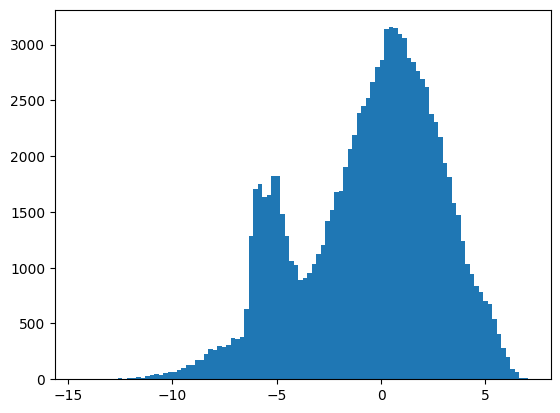

In [15]:
plt.hist(activity_df['expression_log2'],bins=100)
plt.show()

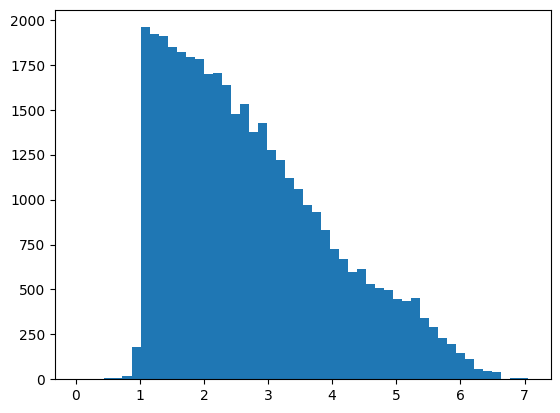

0.0281362837447689

In [26]:
enhancer_df = activity_df[activity_df['activity_bin'].isin(['WeakEnhancer','StrongEnhancer']) & (activity_df['expression_log2'] > 0)].copy()
plt.hist(enhancer_df['expression_log2'],bins=50)
plt.show()
min(enhancer_df['expression_log2'].values)

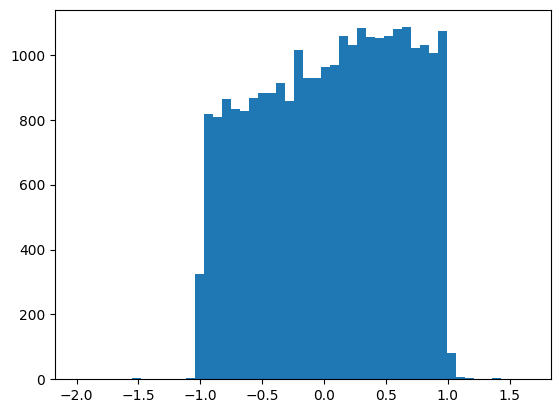

In [27]:
inactive_df = activity_df[(activity_df['activity_bin'] == 'Inactive') & (activity_df['expression_log2'].abs() < 2)].copy()
plt.hist(inactive_df['expression_log2'],bins=50)
plt.show()

In [29]:
df = pd.concat([enhancer_df,inactive_df])

df['enhancer'] = df['activity_bin'].map(lambda x: 0 if x=='Inactive' else 1)


In [30]:
df

,expression,expression_std,expression_reps,mu,sigma,pval,qval,expression_log2,library,sequence,...,random_sampling,high_conf_pilot,high_conf_cnn,l9_controls,l9_repeat_l8,data_batch_name,train_set,validation_set,test_set,enhancer
label,,,,,,,,,,,,,,,,,,,,,
chr1-104768570-104768734_UPCQ_MUT-allCrxSites,3.023710,0.329457,3.0,1.100584,0.108637,0.000136,0.000701,1.596320,library1,GTCACAGCTTTACAGCCTTCGGATGTTTCCAAAGTCTCCGCTCGAT...,...,False,False,False,False,False,CrxMotifMutant,True,False,False,1
chr1-104768570-104768734_UPCQ_WT,3.601919,0.296558,3.0,1.278089,0.082194,0.001224,0.003408,1.848766,library1,GTCACAGCTTTACAGCCTTCGGATGTTTCCAAAGTCTCCGCTCGAT...,...,False,False,False,False,False,Genomic,True,False,False,1
chr1-106008207-106008371_CPPE_MUT-allCrxSites,3.334393,0.395807,3.0,1.197295,0.118289,0.003044,0.006978,1.737424,library1,TAAGCTGAGGGTTACTTCCCATGGCCCTGAAGAATGAGAAGGCATT...,...,False,False,False,False,False,CrxMotifMutant,False,True,False,1
chr1-106008207-106008371_CPPE_WT,2.112594,1.326102,3.0,0.581819,0.576363,0.182241,0.212452,1.079015,library1,TAAGCTGAGGGTTAATTCCCATGGCCCTGAAGAATGAGAAGGCATT...,...,False,False,False,False,False,Genomic,False,True,False,1
chr1-106696554-106696718_CPPE_MUT-allCrxSites,2.496643,0.127562,3.0,0.913644,0.051060,0.000252,0.001062,1.319990,library1,GAGCCACTTGGCTTGGCGTAGGCTTTTGAGATCTCAAAGTCCACCA...,...,False,False,False,False,False,CrxMotifMutant,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr2-155956059-155956223_UPPP_WT,0.469558,0.075820,3.0,-0.909850,0.075499,0.104824,0.128436,-1.090626,library2,GCCAAGTACAGTAACTGGGTGAAAGCACCTAGCTCCAGTTAAATCT...,...,False,False,False,False,False,Genomic,True,False,False,0
chr11-78805986-78806150_CPPE_WT;148iCRX-R,0.610684,0.057729,3.0,-0.812680,0.190928,0.461228,0.467159,-1.130399,library4,CAGAGGAGGGATGAGGAACTCGCAACGATAATCCCTCCCCTTACTA...,...,False,False,False,False,False,Round3a,True,False,False,0
"chr7-29406843-29407007_CBPE_MUT-shape;shufSites7;99mCRX-63,2dCRX-R;37rGFI1-RAX,78dNDF1-R",0.879559,0.242231,3.0,-0.174795,0.269726,0.520025,0.538175,-0.199681,library8b,TTTCAGGAGTGTATTAGGAAATCACTGTAGAGTTGCAATAATTAGT...,...,False,False,False,False,False,Round4a,True,False,False,0


In [31]:
df.to_csv('Data/enhancer.csv')